In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
def generate_synthetic_dataset(num_samples):
    """ Takes num of samples and return the df with one features and two class """
    np.random.seed(0)
    samples = int(num_samples /2)
    label_0 = np.zeros(samples)
    label_1 = np.ones(samples)

    mu_1 = 12
    sigma_1 = 5
    class_1_data = np.random.normal(mu_1, sigma_1, samples)
    mu_0 = 0
    sigma_0 = 4
    class_0_data = np.random.normal(mu_0, sigma_0, samples)
    data  =  np.concatenate((class_0_data, class_1_data)) 
    labels = np.concatenate((label_0, label_1))

    d = {
        "feature": data,
        "Label": labels
    }
    df = pd.DataFrame(data =d)
    return df

    

In [3]:
def data_visualization(df):
    class_0_data = df[df['Label'] == 0]['feature']
    class_1_data = df[df['Label'] == 1]['feature']

    plt.figure()
    sns.kdeplot(class_0_data, color='blue', label='Class 0')
    sns.kdeplot(class_1_data, color='red', label='Class 1')

    plt.scatter(class_0_data, np.zeros_like(class_0_data), color='blue', alpha=0.6, label='Class 0 Samples')
    plt.scatter(class_1_data, np.zeros_like(class_1_data), color='red', alpha=0.6, label='Class 1 Samples')

    plt.title('Class Conditional Density Plot of Feature')
    plt.ylim(-0.05, .15)
    plt.xlabel('Feature')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
def select_model(model):
    if model == "logistic_regression" :
        return LogisticRegression() 
    elif model == "naive_bayes":
        return GaussianNB()
    elif model == "random_forest":
        return RandomForestClassifier(max_depth=2, random_state=0)
    else:
        raise ValueError("Unknown model type: {}".format(model))

In [5]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
df = generate_synthetic_dataset(1000)

X = df[['feature']]
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X, y)
    y_pred = model.predict(X)
    # global performance
    global_accuracy = accuracy_score(y, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")
    


Model name: logistic_regression, global_accuracy: 0.912, Scores for each fold: [0.92  0.915 0.89  0.92  0.91 ], Average_score: 0.9109999999999999
Model name: naive_bayes, global_accuracy: 0.914, Scores for each fold: [0.925 0.925 0.895 0.915 0.905], Average_score: 0.913
Model name: random_forest, global_accuracy: 0.919, Scores for each fold: [0.925 0.935 0.9   0.925 0.9  ], Average_score: 0.9170000000000001


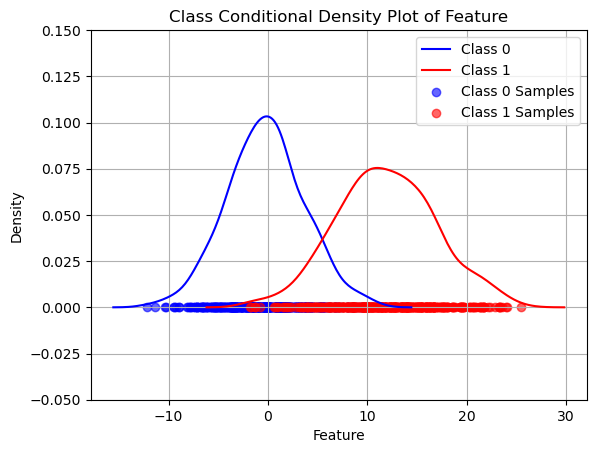

In [6]:
data_visualization(df)

In [29]:
model = select_model("logistic_regression")
model.fit(X,y)


<bound method LinearClassifierMixin.decision_function of LogisticRegression()>

model.

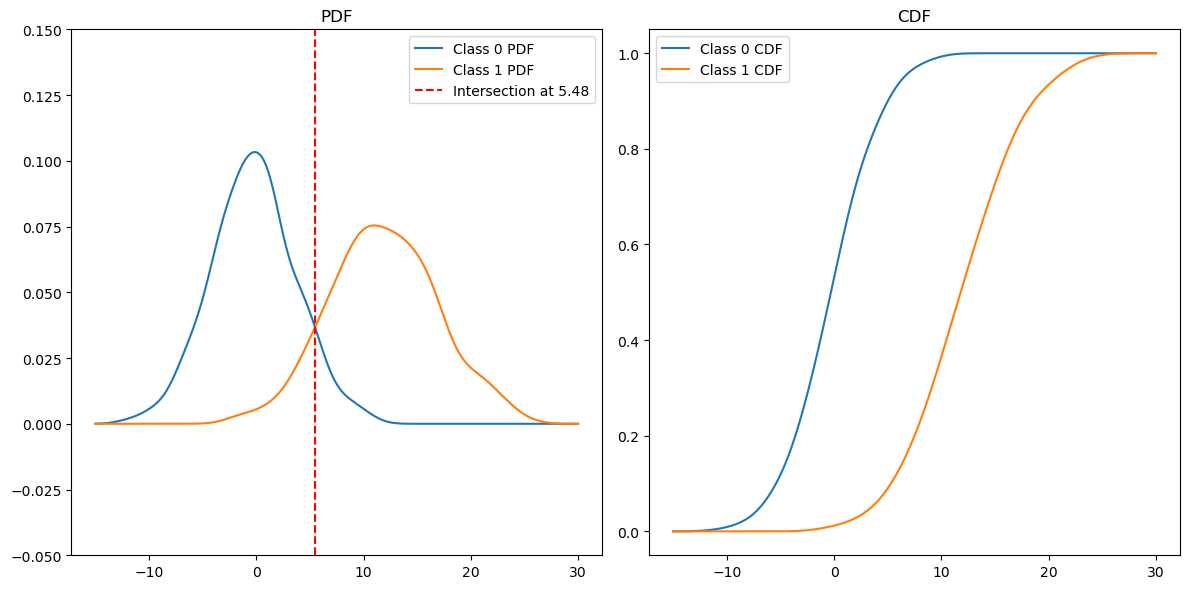

The cross over area between the two pdf is:  0.1881


In [7]:
# Function for the calculate the common area between the two pdf
from scipy import stats
from scipy.integrate import cumulative_trapezoid

def calculate_pdf(df):
    """Calculate pdf using kernel density estimate"""
    class_0_data = df[df["Label"] == 0]["feature"]
    class_1_data = df[df['Label'] == 1]['feature']
    kde1 = stats.gaussian_kde(class_0_data)
    kde2 = stats.gaussian_kde(class_1_data)
    x = np.linspace(-15, 30, 50000)
    y1 = kde1.pdf(x)
    y2 = kde2.pdf(x)
    return x, y1, y2

def calculate_cdf(x, pdf):
    """Calculate cdf from pdf using numerical integration"""
    cdf = cumulative_trapezoid(pdf, x, initial=0)
    cdf /= cdf[-1]  # Normalize to ensure the cdf ranges from 0 to 1
    return cdf

def calculate_crossover_area(x, cdf1, cdf2, intersection_point):
    """ Calculate the common area between intersection point """
    common_area = 1- cdf1[intersection_point] + cdf2[intersection_point]
    return common_area

def plot_pdf_cdf(x, pdf1, cdf1, pdf2, cdf2, intersection):
    """Plot PDF and CDF"""
    plt.figure(figsize=(12, 6))

    # Plot PDF
    plt.subplot(1, 2, 1)
    plt.plot(x, pdf1, label='Class 0 PDF')
    plt.plot(x, pdf2, label='Class 1 PDF')
    plt.axvline(x[intersection], color='red', linestyle='--', label=f'Intersection at {x[intersection]:.2f}')
    plt.title('PDF')
    plt.ylim(-0.05, .15)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, cdf1, label='Class 0 CDF')
    plt.plot(x, cdf2, label='Class 1 CDF')
    plt.title('CDF')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

x, pdf1, pdf2 = calculate_pdf(df)
cdf1 = calculate_cdf(x, pdf1)
cdf2 = calculate_cdf(x, pdf2)

intersection_point = np.argmin(np.abs(pdf1-pdf2))
intersection_point, x[intersection_point], pdf1[intersection_point]
plot_pdf_cdf(x, pdf1, cdf1, pdf2, cdf2, intersection_point)

area = calculate_crossover_area(x, cdf1, cdf2, intersection_point)
print(f"The cross over area between the two pdf is: {area: .4f}")


In [ ]:
# error computation within particular segment 
# Divide the sample space and generate the pdf and cdf
# then calculate the error form them

segment = 10
